# **Requerimientos**

In [ ]:
!pip install astroquery
!pip install alerce

In [ ]:
from alerce.core import Alerce
alerce=Alerce()
import numpy as np; import matplotlib.pyplot as plt
import sys ; import pandas as pd
import seaborn as sns; import os
import requests; import astropy.units as u

from astropy import coordinates
from astropy.time import Time
from astropy.table import Table, Column
from astropy.coordinates import Distance, Galactic, SkyCoord
from astropy.cosmology import WMAP7
from astroquery.ipac.irsa.irsa_dust import IrsaDust
from astroquery.ned import Ned
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets

# **ALeRCE help**

In [ ]:
clasificaciones= alerce.query_classifiers()
print(clasificaciones)

[{'classifier_name': 'lc_classifier_transient', 'classifier_version': 'hierarchical_random_forest_1.0.0', 'classes': ['SNIa', 'SNIbc', 'SNII', 'SLSN']}, {'classifier_name': 'lc_classifier_stochastic', 'classifier_version': 'hierarchical_random_forest_1.0.0', 'classes': ['QSO', 'AGN', 'Blazar', 'CV/Nova', 'YSO']}, {'classifier_name': 'lc_classifier_periodic', 'classifier_version': 'hierarchical_random_forest_1.0.0', 'classes': ['LPV', 'E', 'DSCT', 'RRL', 'CEP', 'Periodic-Other']}, {'classifier_name': 'LC_classifier_ATAT_forced_phot(beta)', 'classifier_version': 'beta', 'classes': ['SNIa', 'SNIbc', 'SNIIb', 'SNII', 'SNIIn', 'SLSN', 'TDE', 'Microlensing', 'QSO', 'AGN', 'Blazar', 'YSO', 'CV/Nova', 'LPV', 'EA', 'EB/EW', 'Periodic-Other', 'RSCVn', 'CEP', 'RRLab', 'RRLc', 'DSCT']}, {'classifier_name': 'LC_classifier_BHRF_forced_phot(beta)', 'classifier_version': 'beta', 'classes': ['SNIa', 'SNIbc', 'SNIIb', 'SNII', 'SNIIn', 'SLSN', 'TDE', 'Microlensing', 'QSO', 'AGN', 'Blazar', 'YSO', 'CV/Nov

In [ ]:
# Getting classes for a classifier and version
classes = alerce.query_classes("lc_classifier",
"hierarchical_random_forest_1.0.0")
print(classes)

[{'name': 'SNIa'}, {'name': 'SNIbc'}, {'name': 'SNII'}, {'name': 'SLSN'}, {'name': 'QSO'}, {'name': 'AGN'}, {'name': 'Blazar'}, {'name': 'CV/Nova'}, {'name': 'YSO'}, {'name': 'LPV'}, {'name': 'E'}, {'name': 'DSCT'}, {'name': 'RRL'}, {'name': 'CEP'}, {'name': 'Periodic-Other'}]


# **Muestras de estrellas variables CEP, RRL, DSCT y LPV**

In [ ]:
#Definir cefeidas

min_firstmjd = Time("2017-11-01T00:00:00", format="isot", scale="utc").mjd

CEPs = alerce.query_objects(classifier="lc_classifier",
                           class_name="CEP",
                           probability=0.7,
                           ndet=[30, 200],
                           order_by="probability",
                           order_mode="DESC",
                           first_mjd=[min_firstmjd, None],
                           count=False,
                           page_size=1000, format='pandas')

CEPs.set_index("oid", inplace=True)

#Definir RR Lyrae

RRs = alerce.query_objects(classifier="lc_classifier",
                           class_name="RRL",
                           probability=0.7,
                           ndet=[30, 200],
                           order_by="probability",
                           order_mode="DESC",
                           first_mjd=[min_firstmjd, None],
                           count=False,
                           page_size=1000, format='pandas')

RRs.set_index("oid", inplace=True)

#Definir Delta Scuti

DSCTs = alerce.query_objects(classifier="lc_classifier",
                           class_name="DSCT",
                           probability=0.7,
                           ndet=[30, 200],
                           order_by="probability",
                           order_mode="DESC",
                           first_mjd=[min_firstmjd, None],
                           count=False,
                           page_size=1000, format='pandas')

DSCTs.set_index("oid", inplace=True)

#Definir Long period Variables

LPVs = alerce.query_objects(classifier="lc_classifier",
                           class_name="LPV",
                           probability=0.7,
                           ndet=[30, 200],
                           order_by="probability",
                           order_mode="DESC",
                           first_mjd=[min_firstmjd, None],
                           count=False,
                           page_size=1000, format='pandas')

LPVs.set_index("oid", inplace=True)

In [ ]:
cep_ar = CEPs["meanra"].values
cep_dec = CEPs["meandec"].values

rr_ar = RRs["meanra"].values
rr_dec = RRs["meandec"].values

dsct_ar = DSCTs["meanra"].values
dsct_dec = DSCTs["meandec"].values

lvp_ar = LPVs["meanra"].values
lvp_dec = LPVs["meandec"].values

def equatorial_to_galactic(ra, dec):
    """Convierte coordenadas ecuatoriales (RA, Dec) a galácticas (l, b)."""
    ra_rad = np.radians(ra)
    dec_rad = np.radians(dec)

    X_eq = np.cos(ra_rad) * np.cos(dec_rad)
    Y_eq = np.sin(ra_rad) * np.cos(dec_rad)
    Z_eq = np.sin(dec_rad)

    l_rad = np.arctan2(Y_eq, X_eq)
    b_rad = np.arcsin(Z_eq / np.sqrt(X_eq**2 + Y_eq**2 + Z_eq**2))

    l = np.degrees(l_rad)
    b = np.degrees(b_rad)

    return l, b

# Convertir las coordenadas de ambos tipos de estrellas
cep_l, cep_b = equatorial_to_galactic(cep_ar, cep_dec)
rr_l, rr_b = equatorial_to_galactic(rr_ar, rr_dec)
dsct_l,dsct_b=equatorial_to_galactic(dsct_ar,dsct_dec)
lvp_l,lvp_b=equatorial_to_galactic(lvp_ar,lvp_dec)

# Convertir a radianes para el gráfico en proyección galáctica
l_rad_cep = np.radians(cep_l)
b_rad_cep = np.radians(cep_b)

l_rad_rr = np.radians(rr_l)
b_rad_rr = np.radians(rr_b)

l_rad_dsct = np.radians(dsct_l)
b_rad_dsct = np.radians(dsct_b)
l_rad_lpv = np.radians(lvp_l)
b_rad_lpv = np.radians(lvp_b)



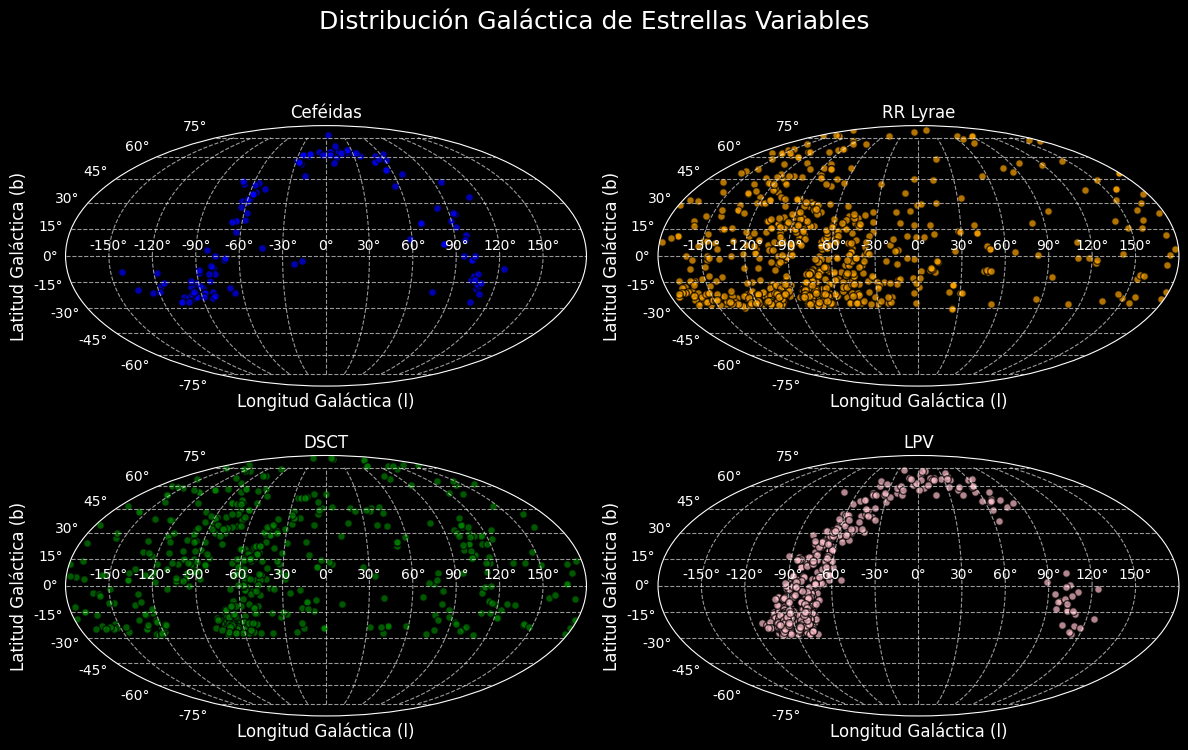

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Crear una figura con 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8), subplot_kw={'projection': 'mollweide'})
fig.suptitle("Distribución Galáctica de Estrellas Variables", fontsize=18)

# Subplot 1: Ceféidas
axes[0, 0].scatter(l_rad_cep, b_rad_cep, c="blue", alpha=0.7, s=30, label="Ceféidas", edgecolor='black')
axes[0, 0].set_title("Ceféidas")
axes[0, 0].grid(True, linestyle='--', alpha=0.6)

# Subplot 2: RR Lyrae
axes[0, 1].scatter(l_rad_rr, b_rad_rr, c="orange", alpha=0.7, s=30, label="RR Lyrae", edgecolor='black')
axes[0, 1].set_title("RR Lyrae")
axes[0, 1].grid(True, linestyle='--', alpha=0.6)

# Subplot 3: DSCT
axes[1, 0].scatter(l_rad_dsct, b_rad_dsct, c="green", alpha=0.7, s=30, label="DSCT", edgecolor='black')
axes[1, 0].set_title("DSCT")
axes[1, 0].grid(True, linestyle='--', alpha=0.6)

# Subplot 4: LPV
axes[1, 1].scatter(l_rad_lpv, b_rad_lpv, c="pink", alpha=0.7, s=30, label="LPV", edgecolor='black')
axes[1, 1].set_title("LPV")
axes[1, 1].grid(True, linestyle='--', alpha=0.6)

# Ajustar la visualización y mostrar
for ax in axes.flat:
    ax.set_xlabel("Longitud Galáctica (l)", fontsize=12)
    ax.set_ylabel("Latitud Galáctica (b)", fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar para el título principal
plt.show()

In [ ]:
cefeida = "ZTF17aaawfxc"

In [ ]:
def plot_diffLC(oid, LC_det, LC_nondet):

    fig, ax = plt.subplots(figsize = (14, 8))
    labels = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    markers = {1: 'o', 2: 's'}

    # loop the passbands
    for fid in [1, 2]:

        # plot detections if available
        mask = LC_det.fid == fid
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(LC_det[mask].mjd, LC_det[mask].magpsf,
                yerr = LC_det[mask].sigmapsf, c = colors[fid], fmt=markers[fid], label = labels[fid])

        # plot non detections if available and if wanted:
        mask = (LC_nondet.fid == fid) & (LC_nondet.diffmaglim > -900)
        if (np.sum(mask) > 0):
            # non detections index is mjd
            ax.scatter(LC_nondet[mask].mjd, LC_nondet[mask].diffmaglim, c = colors[fid], alpha = 0.5,
                marker = 'v', label = "lim.mag. %s" % labels[fid])

    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("difference magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.show()

In [ ]:
def plot_corrLC(oid, LC_det):

    fig, ax = plt.subplots(figsize = (14, 8))
    labels = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    markers = {1: 'o', 2: 's'}

    # loop the passbands
    for fid in [1, 2]:

        # plot detections if available
        mask = LC_det.fid == fid
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(LC_det[mask].mjd, LC_det[mask].magpsf_corr,
                yerr = LC_det[mask].sigmapsf_corr_ext, c = colors[fid], fmt=markers[fid], label = labels[fid])


    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Apparent magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])


In [ ]:
def get_DR(oid, url="https://api.alerce.online/ztf/dr/v1/light_curve/"):
    stats = alerce.query_object(oid, format='pandas')

    ra = float(stats.meanra)
    dec = float(stats.meandec)
    query = {'ra':ra, 'dec':dec, 'radius':1.5}

    response = requests.get(url, query)
    output = response.json()

    df = []
    for i in output:
        aux = pd.DataFrame({'hmjd': np.array(i["hmjd"]), 'mag': np.array(i["mag"]), "magerr": np.array(i["magerr"])})
        aux["ID"] = int(i["_id"])
        aux["filterid"] = int(i["filterid"])
        aux["oid"] = oid
        df.append(aux)

    if df != []:
        return pd.concat(df) #output
    else:
        return None

In [ ]:
# get candidate ZTF data release information
DR = get_DR(cefeida)
print(DR.columns)

Index(['hmjd', 'mag', 'magerr', 'ID', 'filterid', 'oid'], dtype='object')


<ipython-input-66-796714ba3806>:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ra = float(stats.meanra)
<ipython-input-66-796714ba3806>:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dec = float(stats.meandec)


In [ ]:
def plot_corrLC_DR(oid, LC_det, DR):

    fig, ax = plt.subplots(figsize = (14, 8))
    labels = {1: 'g', 2: 'r'}
    labels1 = {1: 'g DR', 2: 'r DR'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    colors1 = {1: '#ADA3A3', 2: '#377EB8',}
    markers = {1: 'o', 2: 's'}

    # loop the passbands
    for fid in [1, 2]:

        # plot detections if available
        mask = LC_det.fid == fid
        maskDR = DR.filterid == fid
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(DR[maskDR].hmjd, DR[maskDR].mag,
                yerr = DR[maskDR].magerr, c = colors1[fid], fmt=markers[fid], label = labels1[fid], alpha=.3)
            ax.errorbar(LC_det[mask].mjd, LC_det[mask].magpsf_corr,
                yerr = LC_det[mask].sigmapsf_corr_ext, c = colors[fid], fmt=markers[fid], label = labels[fid])



    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Apparent magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

In [ ]:
def getLCdata(oid, doLC = False,  plot_diff = False, doDR = False):

    # show link
    display(HTML("<a href='http://alerce.online/object/%s' target=\"_blank\"> %s <a>" % (oid, oid)))

    results = {"oid": oid}

    # query detections
    LC_det = alerce.query_detections(oid, format='pandas')
    results["lc_det"] = LC_det

    # query non detections
    LC_nondet = alerce.query_non_detections(oid, format='pandas')
    results["lc_nondet"] = LC_nondet

    # plot the LC
    if doLC:
        if plot_diff:
            plot_diffLC(oid, LC_det, LC_nondet)
        else:
            plot_corrLC(oid, LC_det)

    # plot the LC
    if doDR:
        if plot_diff:
            plot_diffLC(oid, LC_det, LC_nondet)
        else:
            plot_corrLC_DR(oid, LC_det, DR)

    # return data
    return results

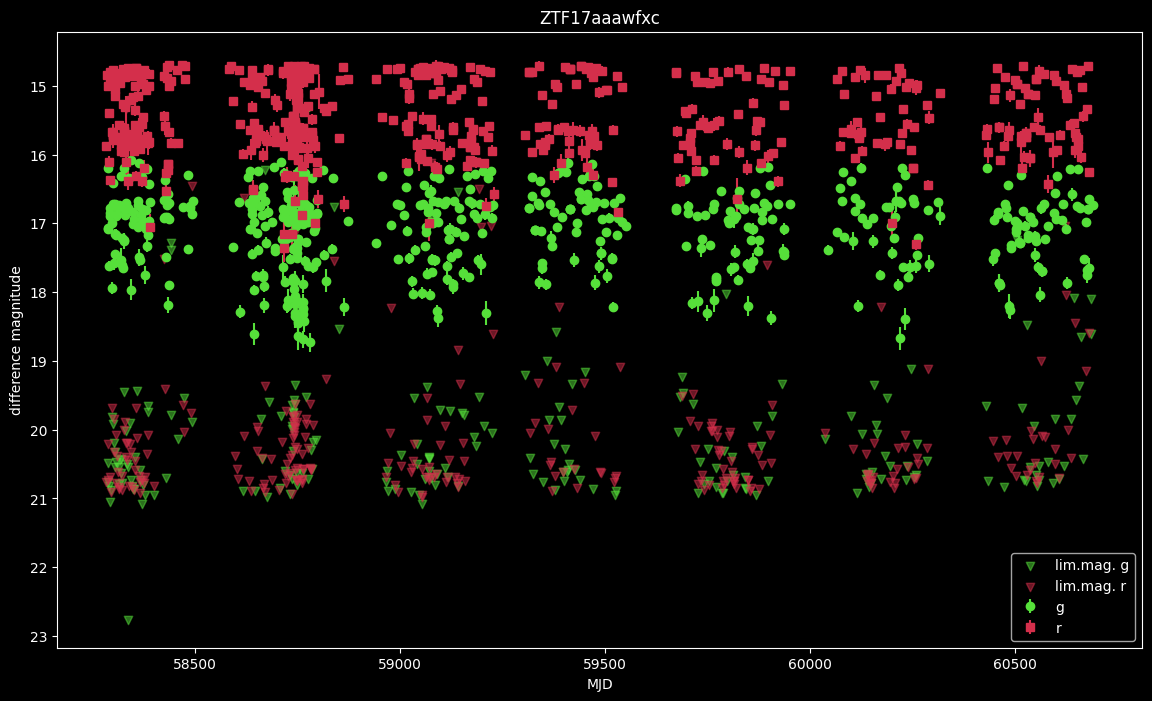

In [ ]:
results = getLCdata(cefeida, doLC=True, plot_diff = True)

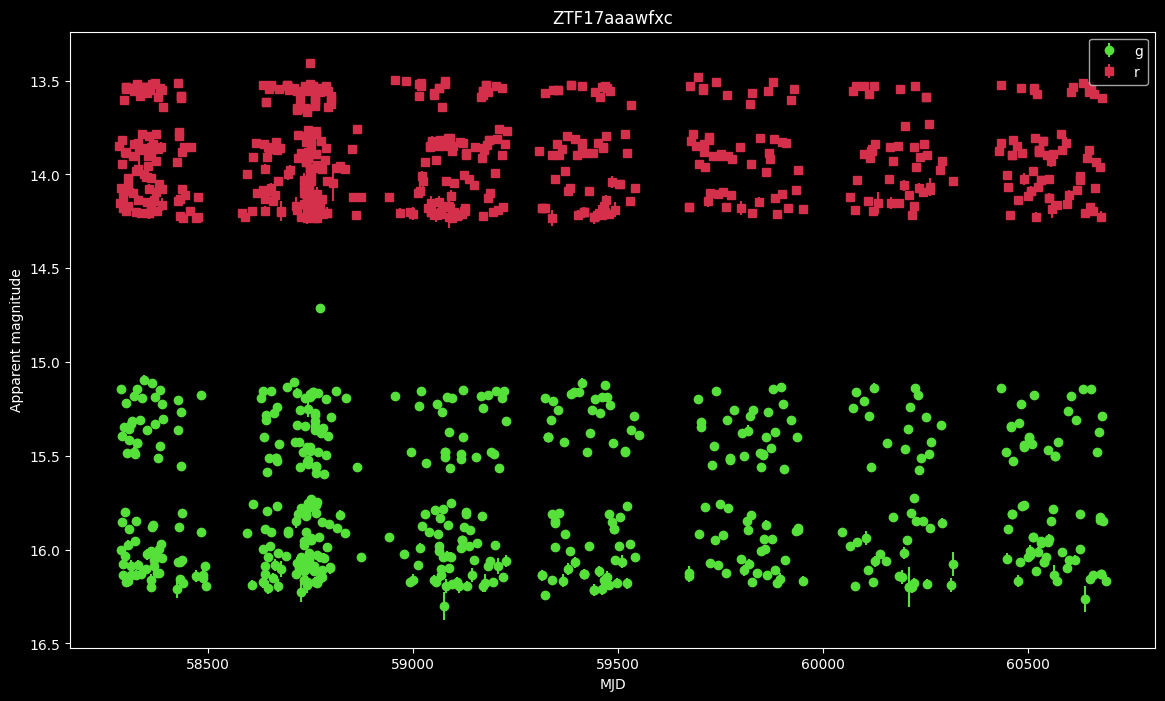

In [ ]:
results = getLCdata(cefeida, doLC=True)

In [ ]:
from astropy.time import Time
import pandas as pd

# Definir el rango inicial para la fecha
min_firstmjd = Time("2017-11-01T00:00:00", format="isot", scale="utc").mjd

try:
    # Consultar objetos cefeidas
    CEPs = alerce.query_objects(
        classifier="lc_classifier",
        class_name="CEP",
        probability=0.7,
        ndet=[30, 200],
        order_by="probability",
        order_mode="DESC",
        first_mjd=[min_firstmjd, None],
        count=False,
        page_size=1000,
        format="pandas"
    )

    # Verificar si se devolvieron datos
    if CEPs.empty:
        print("No se encontraron cefeidas con los criterios especificados.")
    else:
        # Establecer el índice para el dataframe
        CEPs.set_index("oid", inplace=True)

        # Obtener lista de oids de las cefeidas
        cefeidas_oidslist = CEPs.index.tolist()

        # Mostrar la lista de oids
        print("Lista de oids:")
        print(cefeidas_oidslist)
except Exception as e:
    print(f"Error durante la consulta o el procesamiento: {e}")


Lista de oids:
['ZTF18abdpxko', 'ZTF18abmezau', 'ZTF18aawvswi', 'ZTF17aaaidjf', 'ZTF18adjwpst', 'ZTF17aaddvih', 'ZTF18adjxfjs', 'ZTF18abomngy', 'ZTF18adljuxi', 'ZTF18acejbpx', 'ZTF17aabljdy', 'ZTF17aabwgri', 'ZTF18adjwqts', 'ZTF18ablscpk', 'ZTF18adkgfwy', 'ZTF18acwdzst', 'ZTF18abilgmu', 'ZTF19aaesmac', 'ZTF18abcpcma', 'ZTF18abcyyzg', 'ZTF20aciatje', 'ZTF19aarguyq', 'ZTF19aahsivm', 'ZTF18adlkgwv', 'ZTF18acmfbcw', 'ZTF19abagawp', 'ZTF19abgnjtn', 'ZTF19aauyssj', 'ZTF20acqjetk', 'ZTF18acmwtbr', 'ZTF17aabpnen', 'ZTF18abxbezf', 'ZTF18adkgflw', 'ZTF17aaarucn', 'ZTF18adblyjg', 'ZTF18achmasq', 'ZTF19abafwix', 'ZTF18abjpdwu', 'ZTF19acejcgf', 'ZTF18acwsuxp', 'ZTF17aaapdjb', 'ZTF17aaanrbr', 'ZTF19aacebcy', 'ZTF18adkdagg', 'ZTF18abasjak', 'ZTF18aawvlsj', 'ZTF18abomqdy', 'ZTF17aabvyib', 'ZTF17aabuwcq', 'ZTF18admfyug', 'ZTF18adashjn', 'ZTF18acrxiqr', 'ZTF18acweebl', 'ZTF17aabosuj', 'ZTF19abdykej', 'ZTF20acyuzfd', 'ZTF19abholrn', 'ZTF19aahsjls', 'ZTF20aalywsg', 'ZTF20abqpeiq', 'ZTF18abxirla', 'ZTF19ab

In [ ]:
g_r_mean_list = []

for oid in cefeidas_oidslist:
  try:
    # Consultar objeto con alerce.query_objects
    objeto = alerce.query_object(oid, format='pandas')

    # Obtener g_r_mean y agregar a la lista
    g_r_mean_list.append(objeto['g_r_mean'].iloc[0])
  except Exception as e:
    print(f"Error al procesar {oid}: {e}")
    g_r_mean_list.append(np.nan)  # Agregar NaN si hay un error

print(g_r_mean_list)

[None, None, None, None, None, None, None, None, None, None, None, 0.8884673, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 0.99730724, None, None, 1.1064558, None, 0.65324414, None, None, None, 1.1655608, None, 1.4496983, None, None, None, None, None, None, 1.0034955, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 0.8490453, None, None, None, None, None, None, None, None, 1.5065366, None, None, None, None, None, None, None, None, None, None, 0.49918747, None, None, 1.2501557, None, None, None, None, None, None, None, None, 1.1238528, None, None, 1.5968127, None, None, None, None, None, 1.1389196, None, None, None, None, None, 0.35491017, 1.5218935, None, None, None, None, None, None, None, None, None, None, None, 0.4193077, None, None, None, None, None, None, None, None, 1.6651008, None, None, None, None]


In [ ]:
g_r_mean_list = []
oid_list = []

for oid in cefeidas_oidslist:
  try:
    # Consultar objeto con alerce.query_objects
    objeto = alerce.query_object(oid, format='pandas')

    # Obtener g_r_mean
    g_r_mean = objeto['g_r_mean'].iloc[0]

    # Verificar si g_r_mean es distinto de None
    if g_r_mean is not None:
      g_r_mean_list.append(g_r_mean)
      oid_list.append(oid)  # Guardar el oid correspondiente

  except Exception as e:
    print(f"Error al procesar {oid}: {e}")

# Imprimir las listas
print("g_r_mean_list:", g_r_mean_list)
print("oid_list:", oid_list)

g_r_mean_list: [0.8884673, 0.99730724, 1.1064558, 0.65324414, 1.1655608, 1.4496983, 1.0034955, 0.8490453, 1.5065366, 0.49918747, 1.2501557, 1.1238528, 1.5968127, 1.1389196, 0.35491017, 1.5218935, 0.4193077, 1.6651008]
oid_list: ['ZTF17aabwgri', 'ZTF17aabpnen', 'ZTF17aaarucn', 'ZTF18achmasq', 'ZTF18acwsuxp', 'ZTF17aaanrbr', 'ZTF17aabuwcq', 'ZTF18adbldoc', 'ZTF18acwshxi', 'ZTF20abzzmwd', 'ZTF18abuvygx', 'ZTF19aaxhoav', 'ZTF20abjvyjs', 'ZTF19acpbmbs', 'ZTF19ackrbua', 'ZTF18abjhztt', 'ZTF19aamokbz', 'ZTF18acjktye']


In [ ]:
grcefe=np.array([0.8884673, 0.99730724, 1.1064558, 0.65324414, 1.1655608, 1.4496983, 1.0034955, 0.8490453, 1.5065366, 0.49918747, 1.2501557, 1.1238528, 1.5968127, 1.1389196, 0.35491017, 1.5218935, 0.4193077, 1.6651008])
oidscefe=np.array(['ZTF17aabwgri', 'ZTF17aabpnen', 'ZTF17aaarucn', 'ZTF18achmasq', 'ZTF18acwsuxp', 'ZTF17aaanrbr', 'ZTF17aabuwcq', 'ZTF18adbldoc', 'ZTF18acwshxi', 'ZTF20abzzmwd', 'ZTF18abuvygx', 'ZTF19aaxhoav', 'ZTF20abjvyjs', 'ZTF19acpbmbs', 'ZTF19ackrbua', 'ZTF18abjhztt', 'ZTF19aamokbz', 'ZTF18acjktye'])

In [ ]:
print(len(oidscefe))

18


In [ ]:
teff=[]
for k in range(len(oidscefe)):
  te=4600 * (
        1 / (0.92 * grcefe[k]+ 1.7) + 1 / (0.92 * grcefe[k] + 0.62)
    )
  teff.append(te)

In [ ]:
print(teff)
print(oidscefe)

[5027.534511403989, 4749.212709784213, 4500.8654910986315, 5766.595442455597, 4377.431123860433, 3870.7688082866607, 4734.361250034708, 5137.084054617679, 3783.701127442943, 6392.576271453126, 4212.613718740692, 4463.78040315636, 3653.4701930183405, 4432.177350999345, 7129.825519015184, 3760.8706195554214, 6779.0695714878475, 3560.967581157927]
['ZTF17aabwgri' 'ZTF17aabpnen' 'ZTF17aaarucn' 'ZTF18achmasq'
 'ZTF18acwsuxp' 'ZTF17aaanrbr' 'ZTF17aabuwcq' 'ZTF18adbldoc'
 'ZTF18acwshxi' 'ZTF20abzzmwd' 'ZTF18abuvygx' 'ZTF19aaxhoav'
 'ZTF20abjvyjs' 'ZTF19acpbmbs' 'ZTF19ackrbua' 'ZTF18abjhztt'
 'ZTF19aamokbz' 'ZTF18acjktye']


In [ ]:
print(len(teff))

18


In [ ]:
!pip install P4J


In [ ]:
import P4J

In [ ]:
def getVSdatacorr(oid, doLC=False, doext=False, dostamp=False, dosimbad=False, showlink=False):

    results = {"oid": oid}

    # query basic stats
    VS_stats = alerce.query_object(oid, format='pandas')
    results["stats"] = VS_stats

    # query magnitude stats
    VS_magstats = alerce.query_magstats(oid, format='pandas')
    results["magstats"] = VS_magstats

    # query detections
    VS_det = alerce.query_detections(oid, format='pandas')
    VS_det = VS_det.sort_values("mjd")
    results["lc_det"] = VS_det

    # object coordinates
    co = coordinates.SkyCoord(ra=float(VS_stats.meanra), dec=float(VS_stats.meandec), unit=(u.deg, u.deg),
                              frame='icrs')

    # get SIMBAD query
    if dosimbad:
        Simbad_table = Simbad.query_region(co, radius=0.01 * u.deg, equinox=2000)
        display(Simbad_table)
        results["simbad_table"] = Simbad_table

    # get Galactic extinction
    if doext:
        # Galactic extinction (use SFD = D.J. Schlegel, D.P. Finkbeiner, & M. Davis (1998, ApJ, 500, 525))
        table = IrsaDust.get_extinction_table(co)
        A = {"g": float(table[table["Filter_name"] == "SDSS g"]["A_SFD"]),
             "r": float(table[table["Filter_name"] == "SDSS r"]["A_SFD"])}
        results["attenuation"] = A

    # plot the LC
    if doLC:
        if doext:
            plotLCcorr(oid, VS_det, A)
        else:
            plotLCcorr(oid, VS_det)

    if showlink:
        display(HTML("<a href='http://dev.alerce.online/object/%s' target=\"_blank\"> %s <a>" % (oid, oid)))

    # show the first image stamp
    if dostamp:
        candid = results["lc_det"].loc[results["lc_det"].has_stamp].candid.min()
        stamps = alerce.get_stamps(oid, candid)
        science, ref, difference = stamps[0].data, stamps[1].data, stamps[2].data
        fig, ax = plt.subplots(ncols=3, figsize=(12, 6))
        for idx, im in enumerate([np.log(science), np.log(ref), difference]):
            ax[idx].imshow(im, cmap='viridis') # Log scale for visualization
            ax[idx].axes.get_xaxis().set_visible(False)
            ax[idx].axes.get_yaxis().set_visible(False)
        ax[0].set_title("oid: %s, candid: %s (science, reference and difference)" % (oid, candid), loc='left')
        fig.subplots_adjust(wspace=0, hspace=0)

    return results

In [ ]:
def doperiod_multiband(VS_det, showperiod=False):

    mjds, mags, errs, fids = VS_det[["mjd", "magpsf_corr", "sigmapsf_corr_ext", "fid"]].dropna().values.T

    # Compute periodogram
    my_per = P4J.MultiBandPeriodogram(method='MHAOV')
    my_per.set_data(mjds, mags, errs, fids)
    my_per.frequency_grid_evaluation(fmin=1e-3, fmax=20.0, fresolution=1e-3)
    my_per.finetune_best_frequencies(fresolution=1e-4, n_local_optima=10)

    best_freq, best_per = my_per.get_best_frequencies()
    freq_mb, per_mb = my_per.get_periodogram()
    period_mb = 1.0 / best_freq[0]

    if showperiod:
        print('Multiband period: %.6f days' % period_mb)

    period = {}
    freq = {}
    per = {}
    labels = {1: 'g', 2: 'r'}

    for fid in [1, 2]:
        freq[fid], per[fid] = my_per.get_periodogram(fid)
        best_freq = my_per.get_best_frequency(fid)
        period[fid] = 1. / best_freq

        if showperiod:
            print("Period %s: %.6f days" % (labels[fid], period[fid]))

    return period_mb, freq_mb, per_mb, period, freq, per

In [ ]:
def plotperiod_multiband(oid, VS_det, dofold=False, showperiodograms=False,
                         period_mb=None, freq_mb=None, per_mb=None,
                         period=None, freq=None, per=None):

    fig, ax = plt.subplots(figsize=(12, 6))
    labels = {1: 'g', 2: 'r'}
    markers = {1: 'o', 2: 's'}
    sizes = {1: 30, 2: 40}

    for idx, fid in enumerate([1, 2]):
        maskdet = VS_det.fid == fid

        if dofold:
            phase = np.mod(VS_det[maskdet].mjd, period_mb) / period_mb
            for nphase in [0, 1]:
                if nphase == 0:
                    label = labels[fid]
                else:
                    label = None
                ax.errorbar(phase + nphase, VS_det[maskdet].magpsf_corr,
                        yerr = VS_det[maskdet].sigmapsf_corr_ext, marker=markers[fid], label=label,
                        markersize=5, linestyle='None')
        else:
            ax.errorbar(VS_det[maskdet].mjd, VS_det[maskdet].magpsf_corr,
                    yerr=VS_det[maskdet].sigmapsf_corr_ext, marker=markers[fid], label=labels[fid],
                    linestyle='None')

    if dofold:
        ax.set_title("%s (multiband period: %.6f days)" % (oid, period_mb))
        ax.set_xlabel("phase")
    else:
        ax.set_title(oid)
        ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

    if dofold and showperiodograms:
        fig, ax = plt.subplots(ncols=3, figsize=(14, 4))

        for idx, fid in enumerate([0, 1, 2]):
            if idx==0:
                ax[idx].plot(freq_mb, per_mb)
                ax[idx].set_title("Multiband periodogram")
                ax[idx].set_xlabel("frequency [1/days]")
            else:
                ax[idx].plot(freq[fid], per[fid])
                ax[idx].set_title("Periodogram %s (period: %.6f days)" % (labels[fid], period[fid]))
                ax[idx].set_xlabel("frequency [1/days]")

In [ ]:
def getLCdata(oid, results, doplot=False, dofold=False, showperiod=False, showperiodograms=False):
    if dofold:
        # get period
        period_mb, freq_mb, per_mb, period, freq, per = doperiod_multiband(results["lc_det"],
                                                                           showperiod=showperiod)
        results["period_multiband"] = period_mb
        results["period_band"] = period
    else:
        period = None; freq = None; per = None
        period_mb = None; freq_mb = None; per_mb = None

    if doplot:
        plotperiod_multiband(oid, results["lc_det"], dofold, showperiodograms,
                             period_mb=period_mb, freq_mb=freq_mb, per_mb=per_mb,
                             period=period, freq=freq, per=per)

    return results

<ipython-input-119-1eb45125d489>:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  co = coordinates.SkyCoord(ra=float(VS_stats.meanra), dec=float(VS_stats.meandec), unit=(u.deg, u.deg),


Multiband period: 6.309148 days
Period g: 6.309148 days
Period r: 6.309148 days


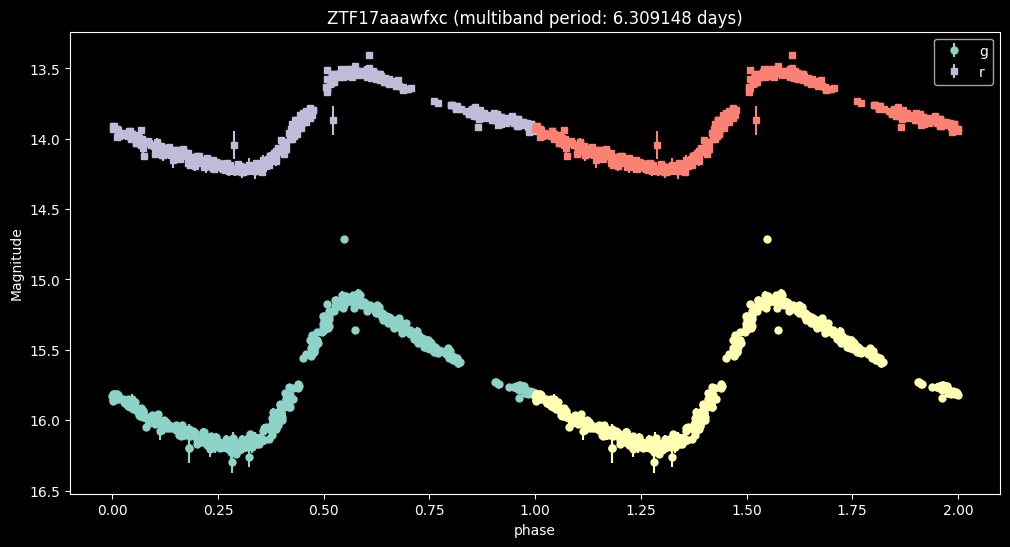

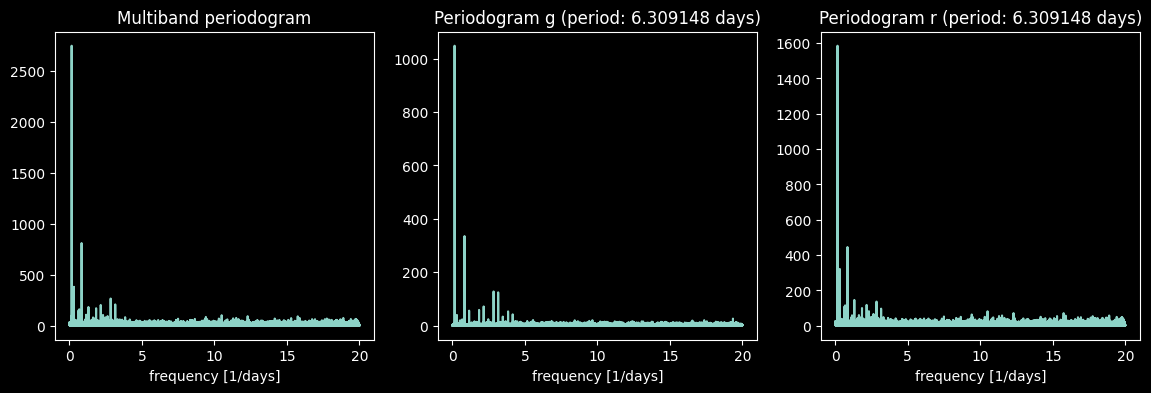

In [ ]:
results = getVSdatacorr(cefeida)
periodogram = getLCdata(cefeida, results, doplot=True, dofold=True, showperiod=True, showperiodograms=True)

In [ ]:
print(teff)

[5027.534511403989, 4749.212709784213, 4500.8654910986315, 5766.595442455597, 4377.431123860433, 3870.7688082866607, 4734.361250034708, 5137.084054617679, 3783.701127442943, 6392.576271453126, 4212.613718740692, 4463.78040315636, 3653.4701930183405, 4432.177350999345, 7129.825519015184, 3760.8706195554214, 6779.0695714878475, 3560.967581157927]


In [ ]:
muktiband_periodosoidscefe=np.array([2.950724,0.763300, 1.499250,1.949318,7.352941,5.091649,0.763300,9.775169,0.818197,1.114454,4.992511,0.598408,4.631774,5.238344,1.669727,1.255808,8.445944,6.131207 ]) # dias

In [ ]:
print(muktiband_periodosoidscefe)

[2.950724 0.7633   1.49925  1.949318 7.352941 5.091649 0.7633   9.775169
 0.818197 1.114454 4.992511 0.598408 4.631774 5.238344 1.669727 1.255808
 8.445944 6.131207]


<ipython-input-119-1eb45125d489>:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  co = coordinates.SkyCoord(ra=float(VS_stats.meanra), dec=float(VS_stats.meandec), unit=(u.deg, u.deg),


Multiband period: 6.131207 days
Period g: 6.131207 days
Period r: 6.131207 days


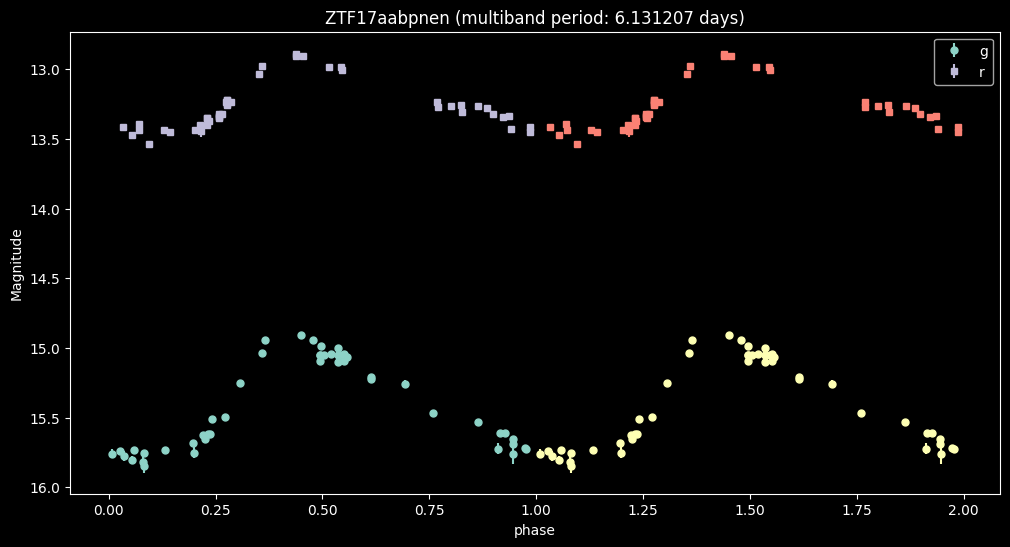

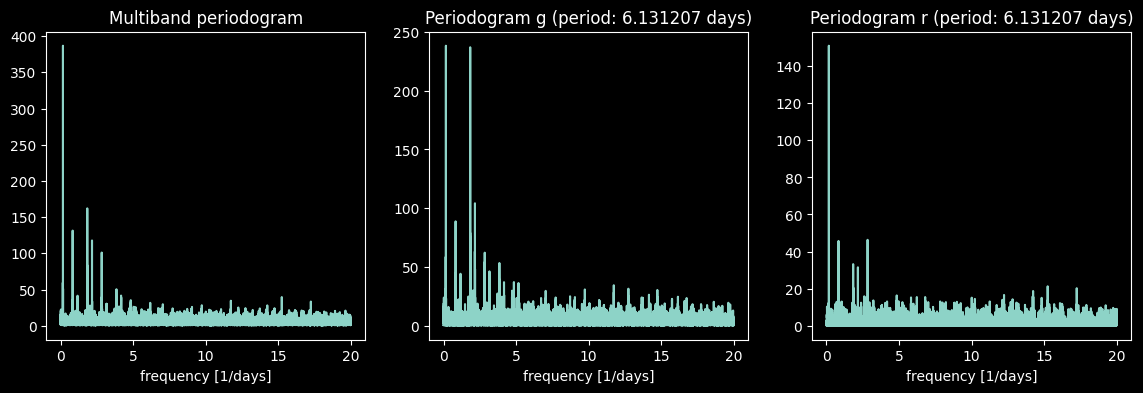

In [ ]:
results = getVSdatacorr(oidscefe[17])
periodogram = getLCdata(oidscefe[1], results, doplot=True, dofold=True, showperiod=True, showperiodograms=True)

In [ ]:
import numpy as np

def calcular_luminosidad_cefeidas(periodos):
  """
  Calcula la luminosidad de las Cefeidas usando la relación Periodo-Luminosidad.

  Args:
    periodos: Una lista o array de NumPy con los periodos de las Cefeidas en días.

  Returns:
    Una lista o array de NumPy con las luminosidades de las Cefeidas en unidades de luminosidad solar.
  """

  # Coeficientes de la relación Periodo-Luminosidad (calibración)
  a = -2.76
  b = -1.43

  # Calcular la luminosidad usando la fórmula: log(L/Lsun) = a * log(P) + b
  luminosidades = 10**(a * np.log10(periodos) + b)

  return luminosidades

# Ejemplo de uso con la lista de periodos:
luminosidades_cefeidas = calcular_luminosidad_cefeidas(muktiband_periodosoidscefe)
print(luminosidades_cefeidas)

[1.87498196e-03 7.82998763e-02 1.21503168e-02 5.88740303e-03
 1.50857677e-04 4.15978283e-04 7.82998763e-02 6.87475147e-05
 6.46416217e-02 2.75491671e-02 4.39176887e-04 1.53280603e-01
 5.40178488e-04 3.84613495e-04 9.02606596e-03 1.98139856e-02
 1.02908435e-04 2.49099639e-04]


Text(0, 0.5, 'Luminosidad')

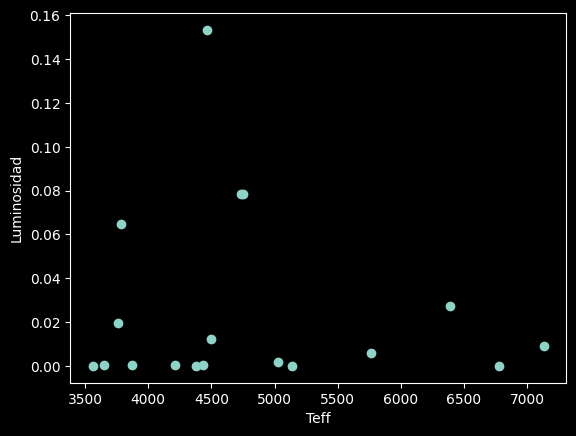

In [ ]:
plt.scatter(teff, luminosidades_cefeidas)
plt.xlabel('Teff')
plt.ylabel('Luminosidad')